##libraries

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.transform import resize
import xml.etree.ElementTree as ET
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

##preparing image for hog and hog function

In [2]:
root_annots="C:\\Users\\Mohamed\\Desktop\\ML\\image\\Annotation"
root_images = "C:\\Users\\Mohamed\\Desktop\\ML\\image\\Images"

In [3]:
def bounding_box(image ,b):
    bpath = root_annots+str("/"+b+"/"+str(image.split(".")[0]))
    tree = ET.parse(bpath)
    root = tree.getroot()
    objects = root.findall('object')
    for o in objects:
        bndbox = o.find('bndbox') # reading bound box
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

    return (xmin,ymin,xmax,ymax)

##uploading images exetracting hog features

In [4]:
dataset_path = root_images

class_folders = [f.path for f in os.scandir(dataset_path) if f.is_dir()]
images_list=[]
labels_list=[]

sift = cv2.SIFT_create()
sift_features = []


for class_folder in class_folders:
    class_name = os.path.basename(class_folder)


    for image_filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_filename)

        xmin , ymin ,xmax,ymax = bounding_box(image_filename,class_name)
        image = cv2.imread(image_path)
        cropped_img = image[ymin:ymax, xmin:xmax]
        resized_img = cv2.resize(cropped_img, (64, 64))

        labels_list.append(int(class_name))
        images_list.append(resized_img)



In [5]:
labels_list = np.array(labels_list)
images_list = np.array(images_list)

In [6]:
sift_features = []

In [7]:
sift = cv2.SIFT_create()


In [8]:
for img in images_list:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    keypoints, descriptors = sift.detectAndCompute(gray, None)

    sift_features.append(descriptors)

sift_features = np.array(sift_features)

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_13740\3482497958.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_features = np.array(sift_features)


In [9]:
print(sift_features)

[array([[99., 47.,  4., ...,  0.,  0.,  0.],
        [ 0.,  1., 46., ...,  0.,  0.,  1.],
        [ 4., 89., 49., ...,  1.,  0., 14.],
        ...,
        [26., 94., 29., ...,  3., 15.,  4.],
        [18.,  2.,  0., ...,  4.,  0.,  1.],
        [32., 17.,  9., ..., 11.,  4.,  5.]], dtype=float32)
 array([[  0.,   0.,   0., ...,   0.,  26., 149.],
        [ 59.,  10.,   1., ...,   0.,   3.,  16.],
        [  0.,   0.,   0., ...,  73.,  78.,  29.],
        ...,
        [  2.,  57.,  73., ..., 122.,  56.,  21.],
        [ 12.,   1.,   0., ...,   6.,   6.,   7.],
        [  0.,   0.,   0., ...,   3.,   8.,   7.]], dtype=float32)
 array([[30., 14., 18., ...,  0.,  0.,  0.],
        [61.,  1.,  0., ..., 17.,  2.,  0.],
        [ 5., 29., 23., ...,  0.,  0.,  0.],
        ...,
        [ 1.,  2.,  3., ...,  0.,  0.,  0.],
        [56., 69.,  2., ...,  0.,  1.,  7.],
        [10.,  1.,  0., ...,  0.,  0.,  0.]], dtype=float32)
 array([[ 14.,  19.,   4., ...,   0.,   0.,   1.],
        [  2.,  

##logistic regresion model and accuracy test

In [10]:
flat_sift_features = [des.flatten() for des in sift_features]

max_length = max(len(des) for des in flat_sift_features)

padded_sift_features = [np.pad(des, (0, max_length - len(des)), 'constant') for des in flat_sift_features]

X_train, X_test, y_train, y_test = train_test_split(padded_sift_features, labels_list, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg_model = LogisticRegression(C= 0.1 ,penalty = 'l2',solver='liblinear', max_iter=1000)
logreg_model.fit(X_train_scaled, y_train)

y_pred_logreg_scaled = logreg_model.predict(X_test_scaled)
accuracy_logreg_scaled = accuracy_score(y_test, y_pred_logreg_scaled)
print(f'Logistic Regression Accuracy (with Scaling): {accuracy_logreg_scaled}')


Logistic Regression Accuracy (with Scaling): 0.4222222222222222


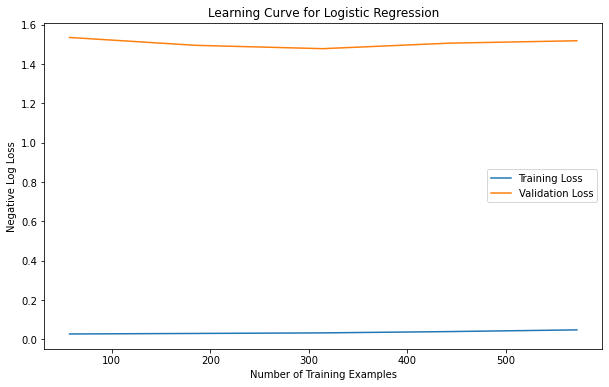

In [11]:
train_sizes, train_scores, test_scores = learning_curve(logreg_model, X_train_scaled, y_train, cv=5, scoring='neg_log_loss')
train_losses_mean = -np.mean(train_scores, axis=1)
test_losses_mean = -np.mean(test_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_losses_mean, label='Training Loss')
plt.plot(train_sizes, test_losses_mean, label='Validation Loss')
plt.xlabel('Number of Training Examples')
plt.ylabel('Negative Log Loss')
plt.title('Learning Curve for Logistic Regression')
plt.legend()
plt.show()

c:\Users\Madiha\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


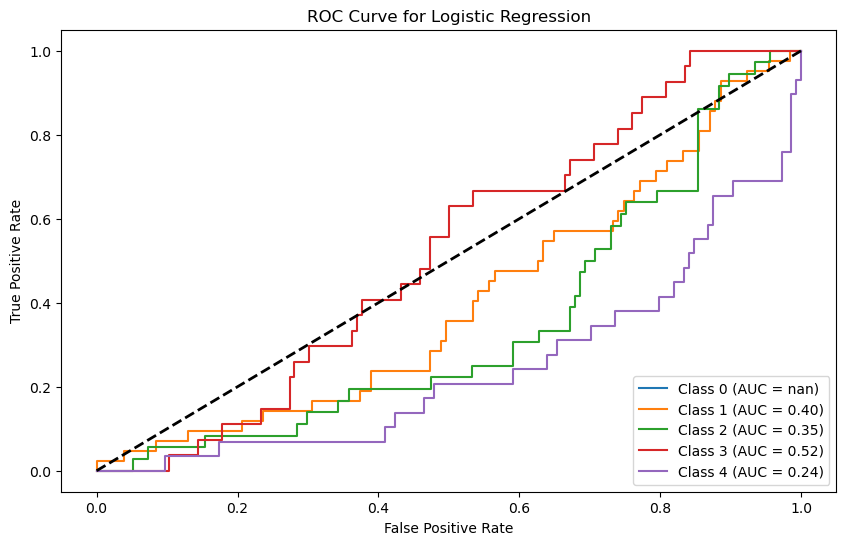

In [12]:
y_probs = logreg_model.predict_proba(X_test_scaled)

plt.figure(figsize=(10, 6))
for i in range(len(logreg_model.classes_)):
    fpr, tpr, _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()


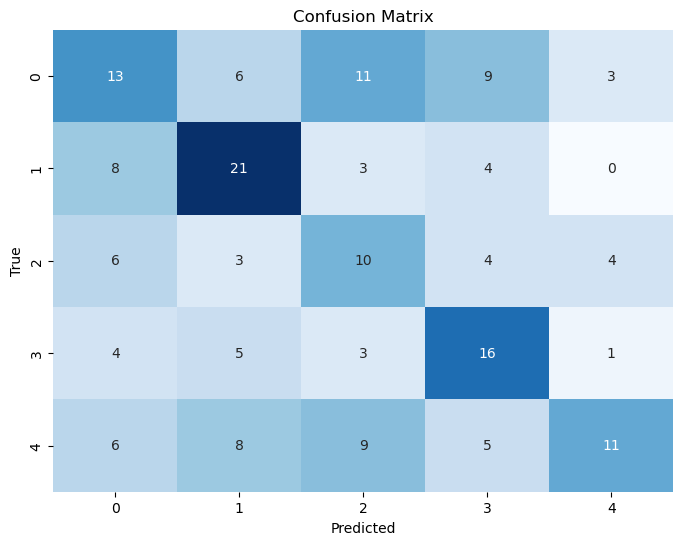

In [13]:
y_pred = logreg_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()